In [1]:
from pathlib import Path
import cv2
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.getcwd()))

### Load dataset and visualize class distribution

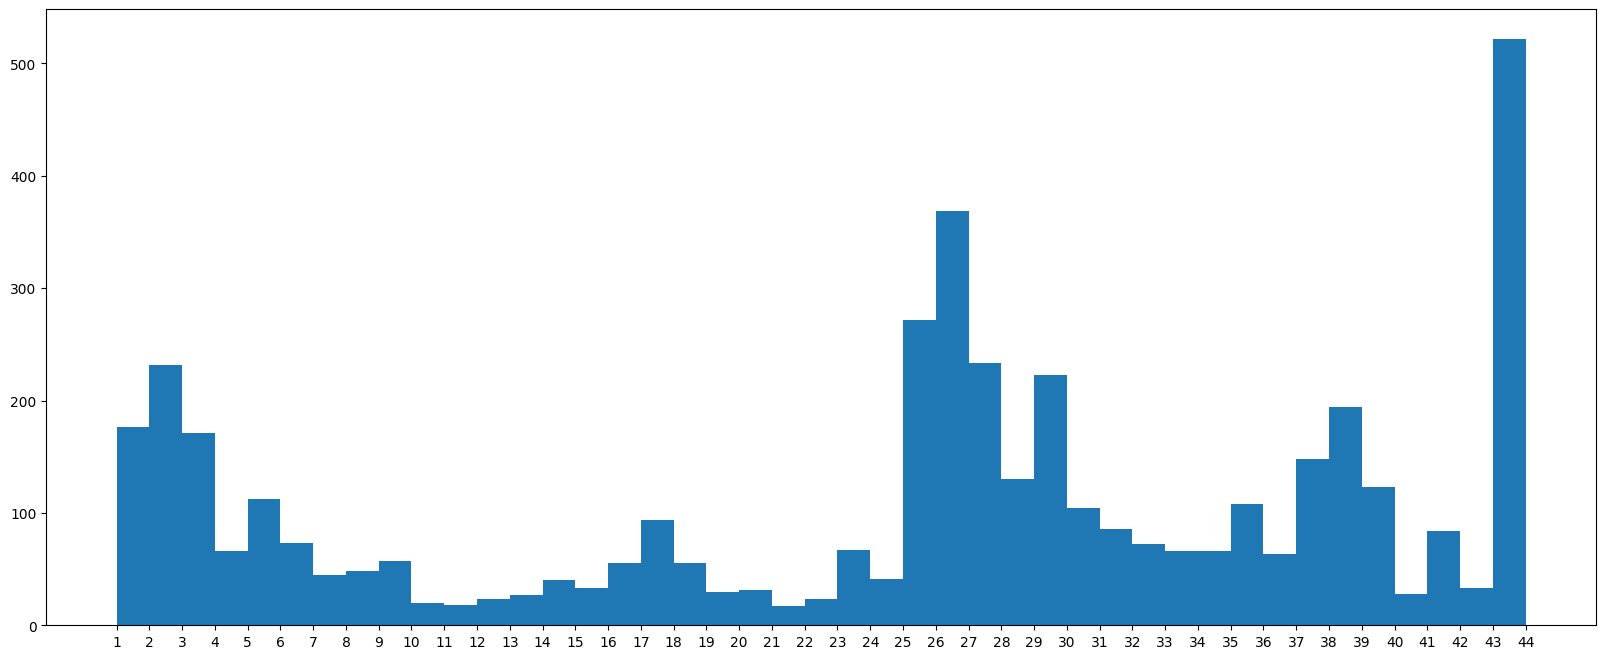

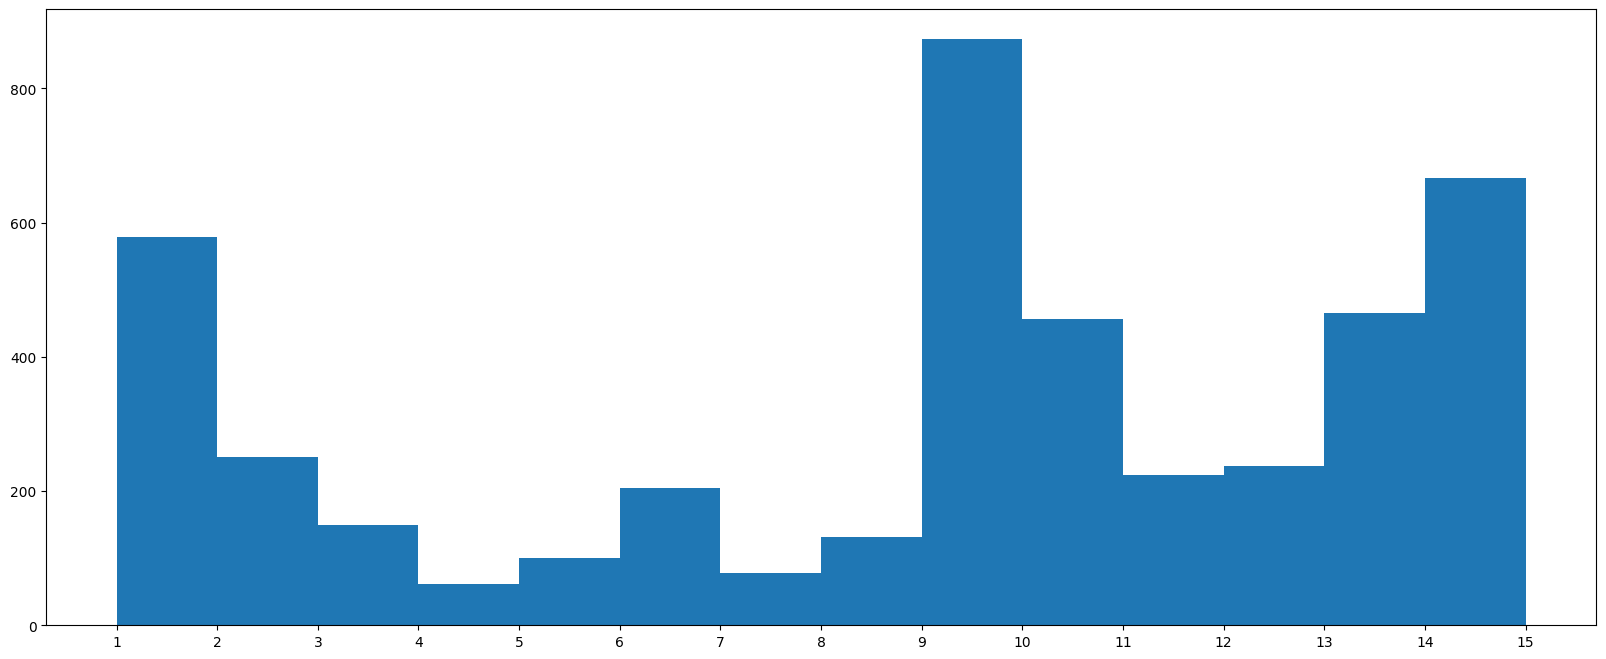

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "brain_tumor_44_classes")
image_list = [data_path + "/" + folder_name + "/" + fname 
                     for folder_name in os.listdir(data_path)
                     if os.path.isdir(data_path + "/" + folder_name)
                     for fname in os.listdir(data_path+ "/" + folder_name)]
cluster_labels = []
shortened_cluster_labels = []
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        for fname in os.listdir(data_path+ "/" + folder_name):
            shortened_cluster_labels.append(folder_name.split(" ")[0])
            cluster_labels.append(folder_name)

label_dict = dict(zip(np.unique(cluster_labels), range(1, len(cluster_labels)+2)))
modified_class = [label_dict[label] for label in cluster_labels]
plt.figure(figsize=(20, 8))
plt.hist(modified_class, bins=list(label_dict.values()))
plt.xticks(list(label_dict.values()))
plt.show()

shortened_label_dict = dict(zip(np.unique(shortened_cluster_labels), range(1, len(shortened_cluster_labels)+2)))
shortened_modified_class = [shortened_label_dict[label] for label in shortened_cluster_labels]
plt.figure(figsize=(20, 8))
plt.hist(shortened_modified_class, bins=list(shortened_label_dict.values()))
plt.xticks(list(shortened_label_dict.values()))
plt.show()

### Class imbalance:

With great class imbalance, we plan to:  
+ Firstly combine the images belong to the same superclass  
+ Secondly choose only those with more than 140 images  
+ Cut short of the number of images from dominant superclasses

In [3]:
count_modified_class = list({i:shortened_modified_class.count(i) for i in shortened_modified_class}.items())
chosen_class = [key for key in shortened_label_dict for k, v in count_modified_class if shortened_label_dict[key] == k if v >= 100]
print(chosen_class)

shortened_cluster_labels = []
image_dict = {}
i = 0
count = 0
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        if folder_name.split(" ")[0] in chosen_class:
            current_class = chosen_class.index(folder_name.split(" ")[0])
            #print("current class:", current_class)
            #print("i:", i)
            if current_class != i:
                i = current_class
                #print("New i:", i)
                count = 0
            for fname in os.listdir(data_path+ "/" + folder_name):
                if count < 200:
                    if folder_name.split(" ")[0] not in image_dict:
                        image_dict[folder_name.split(" ")[0]] = [folder_name + "/" + fname]
                    else:
                        image_dict[folder_name.split(" ")[0]].append(folder_name + "/" + fname)
                    shortened_cluster_labels.append(folder_name.split(" ")[0])
                count += 1

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Germinoma', 'Glioblastoma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL']


### Resize all chosen images to equal size and move them to a different folder

In [4]:
new_data_path = os.path.join(root_path, "shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, (256, 256))
        
        dest = os.path.join(new_data_path, image_name.split('/')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
        if 'jpeg' in image_name.split('/')[1]:
            new_image_name = image_name.split('/')[1][:-5]+'.png'
        else:
            new_image_name = image_name.split('/')[1][:-4]+'.png'
        
        cv2.imwrite(os.path.join(dest, new_image_name), resized_image)
        new_name_list.append(image_name.split('/')[0] + '/' + new_image_name)
    image_dict[tumor_type] = new_name_list

#### Save chosen filenames as a json

In [5]:
json.dump(image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))

### Auxiliary functions for visualizing images' attributes

In [6]:
def visualize_one_per_class(image_dict, data_path):
    col = 4
    row = int((len(image_dict.keys())/4)) + 1
    fig, ax = plt.subplots(row, col, figsize=(col*5, row*5))
    for i in range(len(image_dict.keys())):
        tumor_type = list(image_dict.keys())[i]
        image_path = os.path.join(data_path, image_dict[tumor_type][0])
        if not os.path.exists(image_path):
            print(image_path)
            break
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        x, y = (int(i%4), int(i/4))
        ax[y, x].imshow(image)
        ax[y, x].title.set_text(tumor_type)
    fig.suptitle('One image per class')
    fig.show()
    fig.savefig('each_class_image.png')
def visualize_histogram_per_class(image_dict, data_path):
    col = 4
    row = int((len(image_dict.keys())/4)) + 1
    fig, ax = plt.subplots(row, col, figsize=(col*5, row*5))
    for i in range(len(image_dict.keys())):
        tumor_type = list(image_dict.keys())[i]
        count = np.zeros(256)
        for image_name in image_dict[tumor_type]:
            image_path = os.path.join(data_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            hist = np.histogram(image, 255, range=(0, 256))
            count = hist[0]
        bins = hist[1]
        fig = plt.figure()
        x, y = (int(i%4), int(i/4))
        ax[y, x].bar(bins[:-1], count)
        ax[y, x].title.set_text(tumor_type)
        ax[y, x].set_xticks(range(0, 256, 25))
    fig.suptitle('Pixel distribution of each class')
    fig.show()
    fig.savefig('each_class_histogram.png', dpi=150)

In [7]:
# Visualize shortened dataset:
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Germinoma, Glioblastoma, Meduloblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


/tmp/ipykernel_120492/2790290355.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


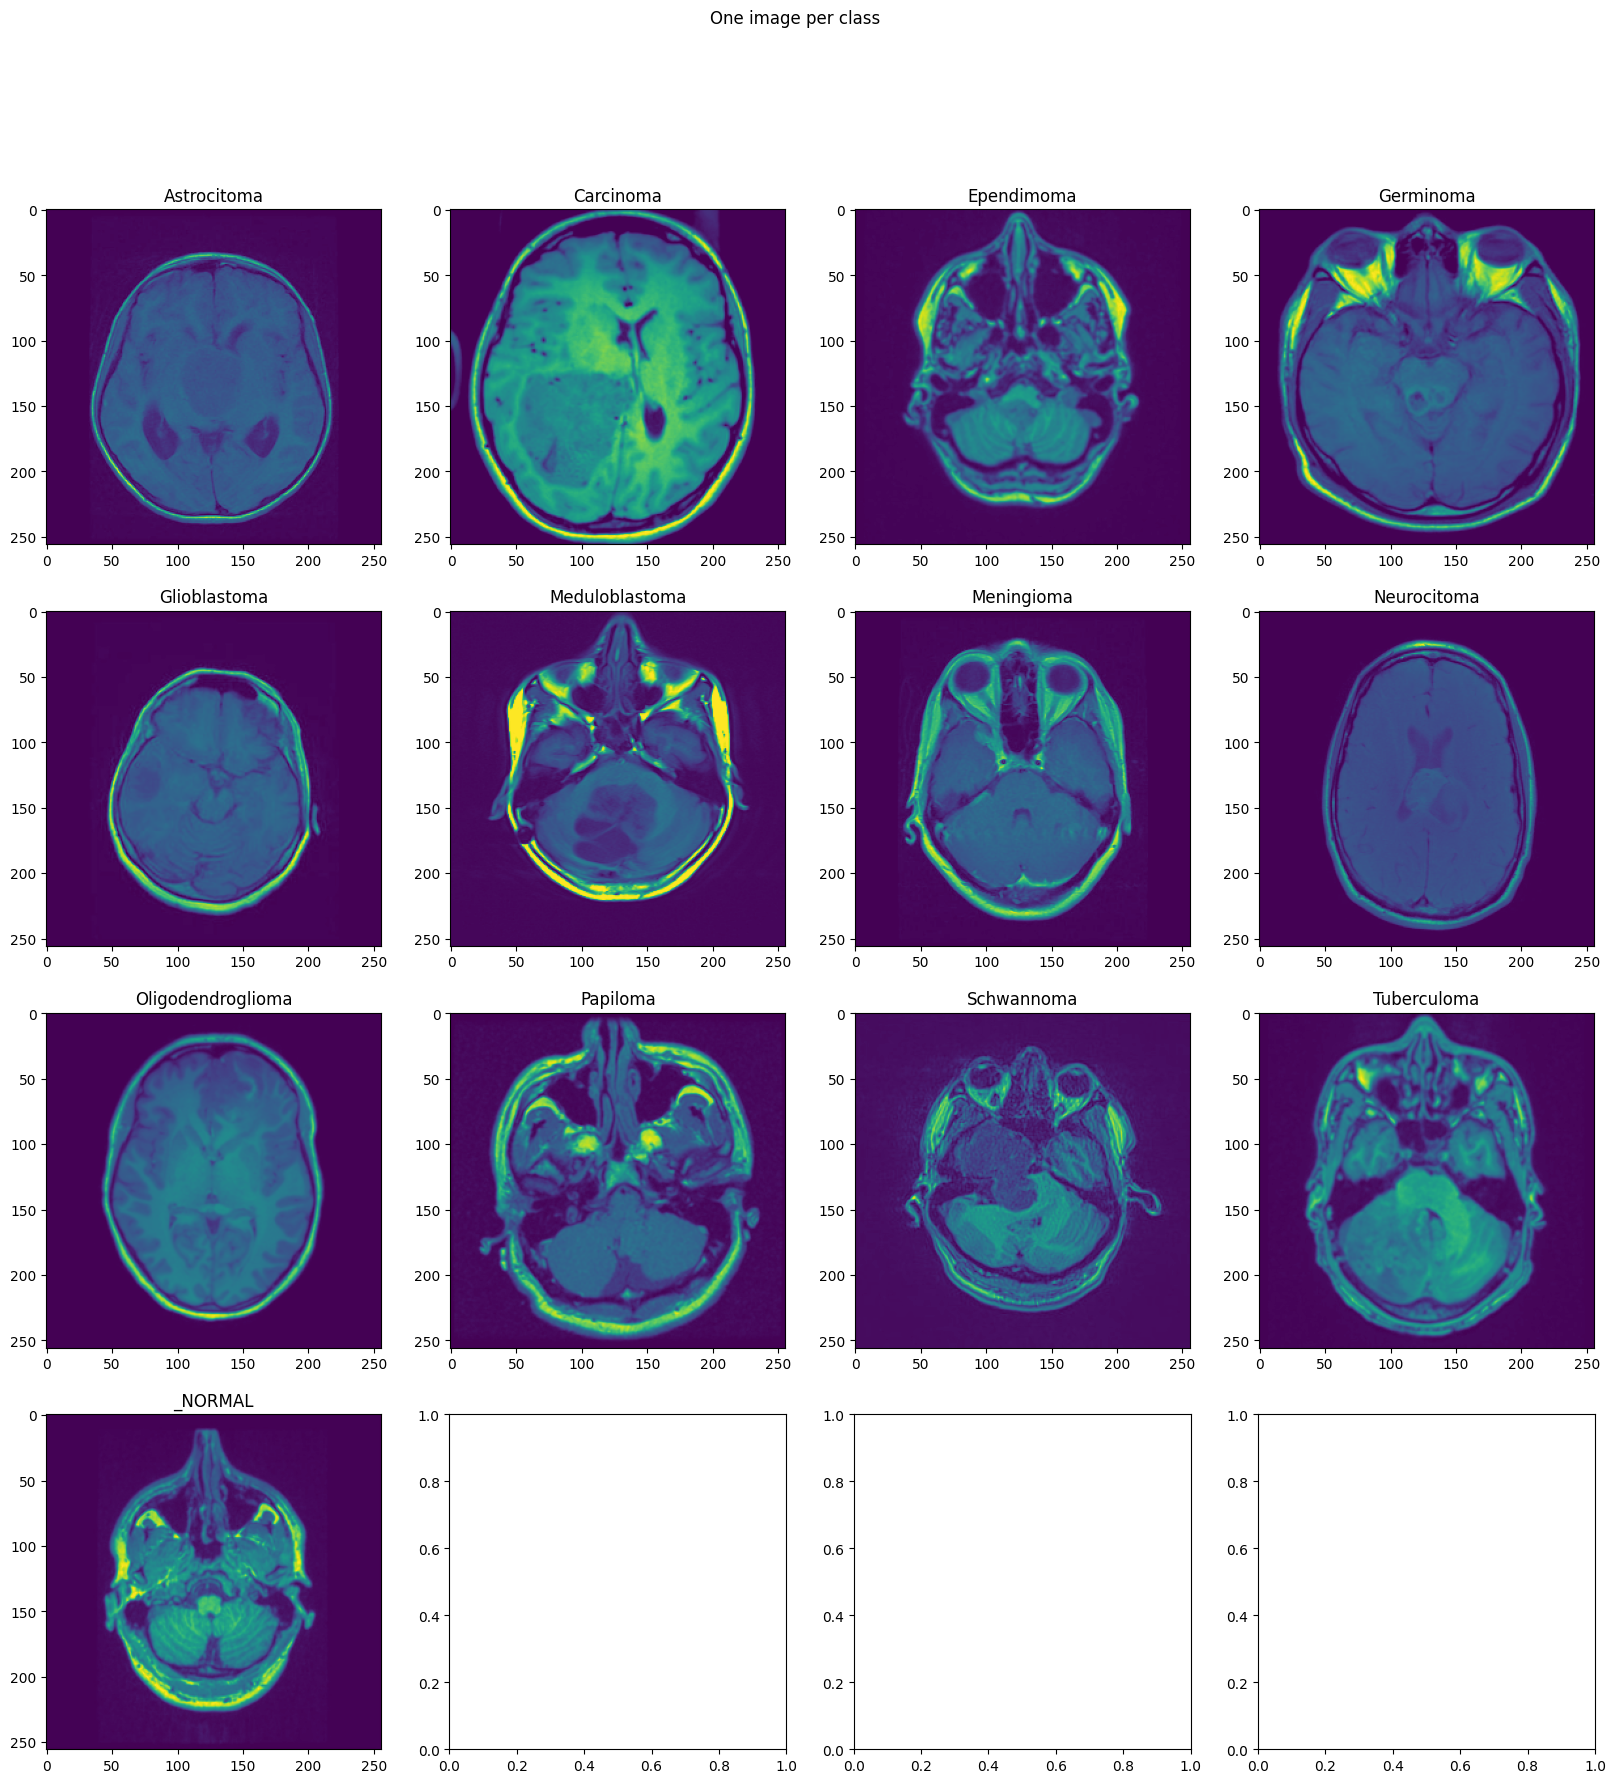

In [8]:
visualize_one_per_class(image_dict, data_path)

/tmp/ipykernel_120492/2790290355.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


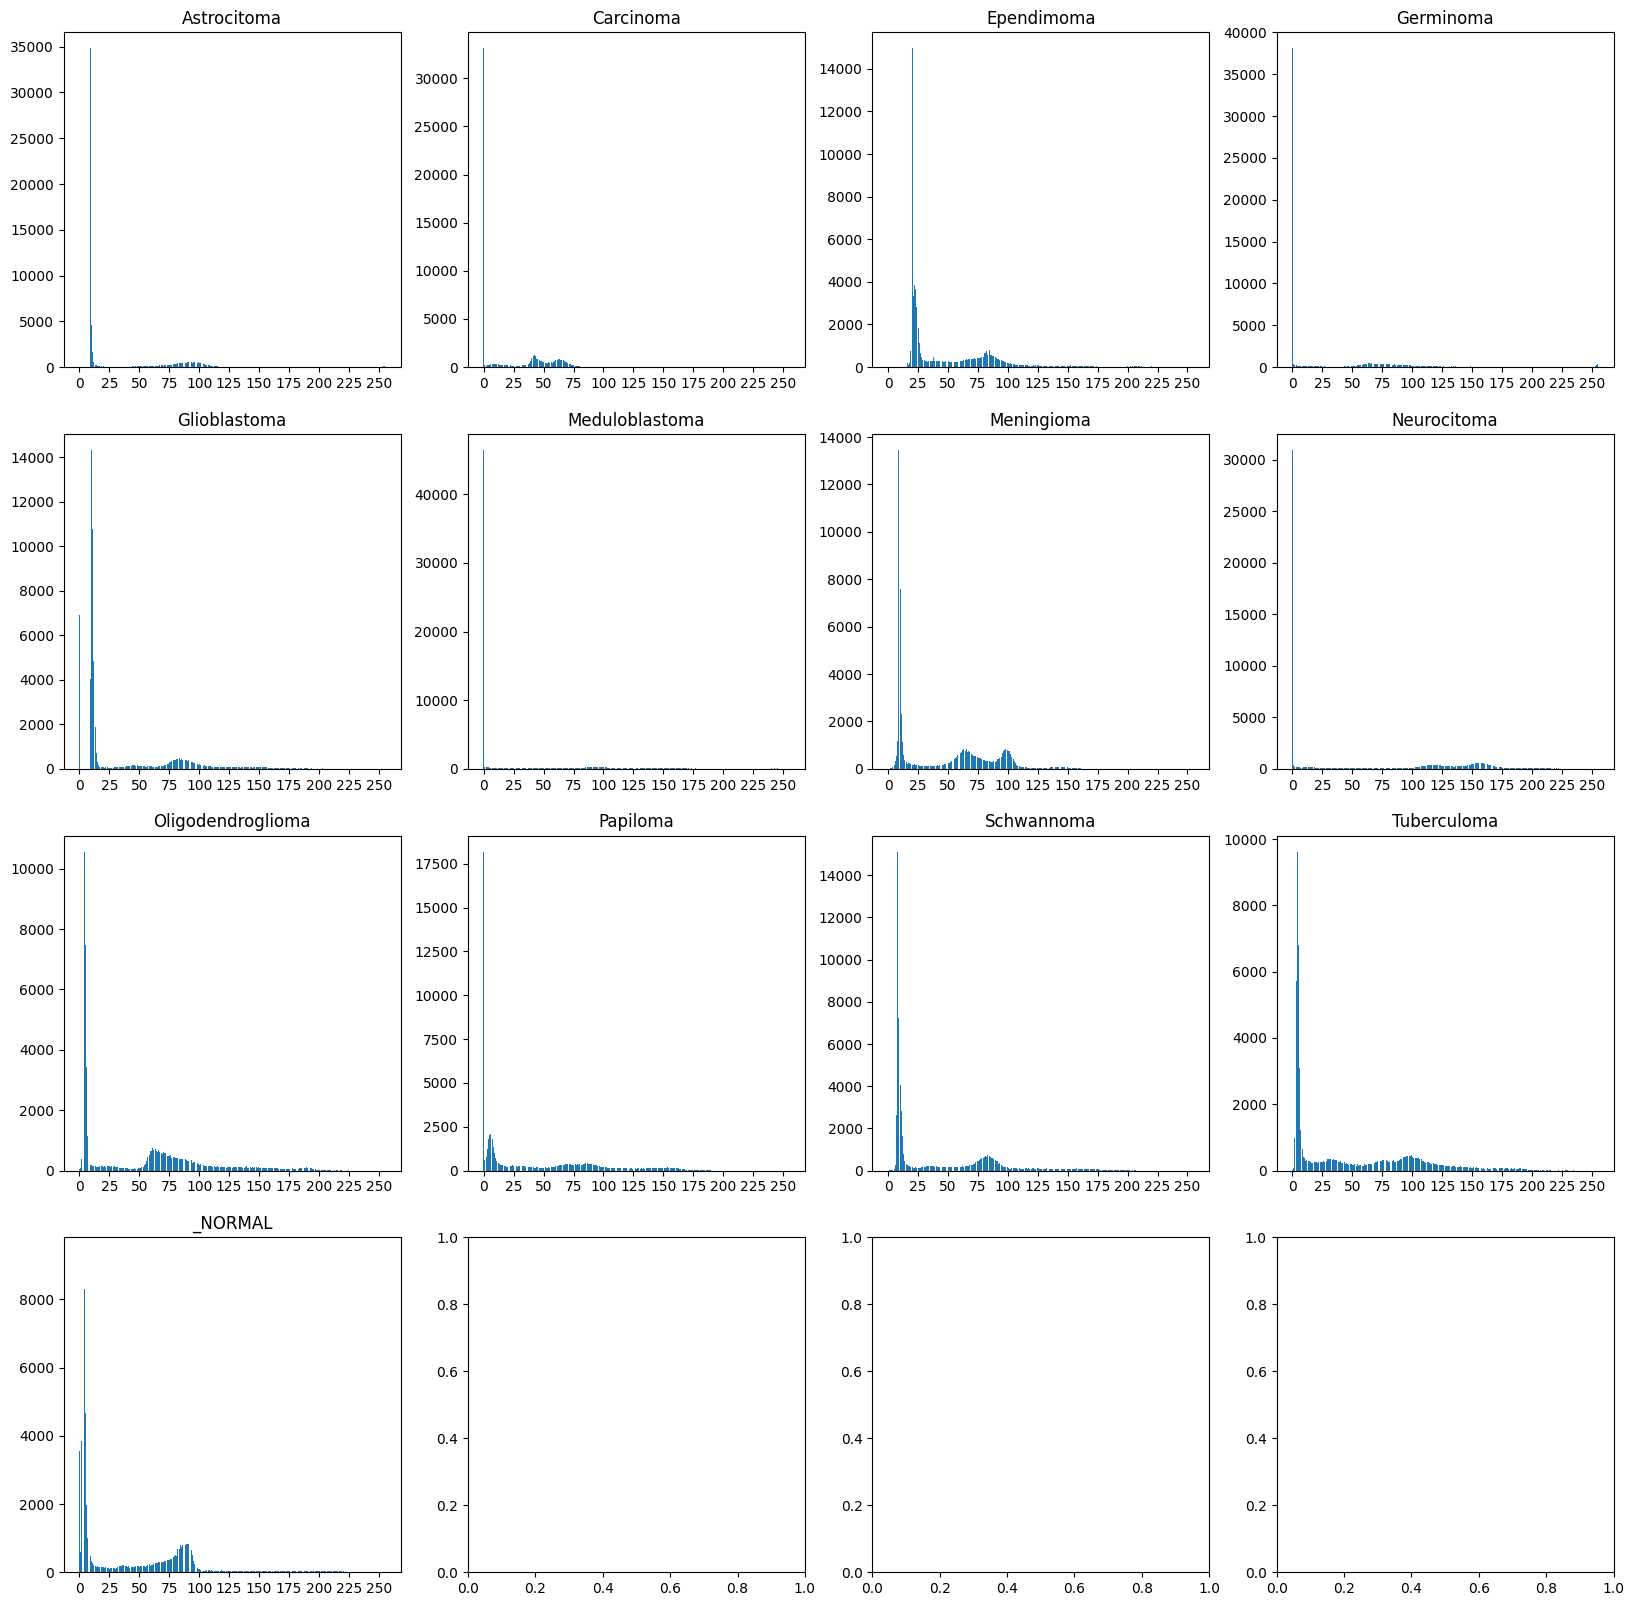

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
visualize_histogram_per_class(image_dict, data_path)

### Data augmentations

#### Contrast stretching

In [10]:
# new_data_path = os.path.join(root_path, "shortened_dataset")
# if not os.path.exists(new_data_path):
#     os.mkdir(new_data_path)
    
# new_image_dict = {}
# for i in range(len(image_dict.keys())):
#     tumor_type = list(image_dict.keys())[i]
#     new_name_list = []
#     for image_name in image_dict[tumor_type]:
#         image_path = os.path.join(data_path, image_name)
#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         resized_image = cv2.resize(image, (256, 256))
        
#         dest = os.path.join(new_data_path, image_name.split('/')[0])
#         if not os.path.exists(dest):
#             os.mkdir(dest)
#         if 'jpeg' in image_name.split('/')[1]:
#             new_image_name = image_name.split('/')[1][:-5]+'.png'
#         else:
#             new_image_name = image_name.split('/')[1][:-4]+'.png'
        
#         cv2.imwrite(os.path.join(dest, new_image_name), resized_image)
#         new_name_list.append(image_name.split('/')[0] + '/' + new_image_name)
#     image_dict[tumor_type] = new_name_list

In [18]:
image_path = "/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/shortened_dataset/Astrocitoma T1/0c14dccd685d7ce330d14fa7a1f53dc756e73aff2f03afc1b09a7efc410f1804_big_gallery.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

### Image segmentation

#### Segmentation by contour

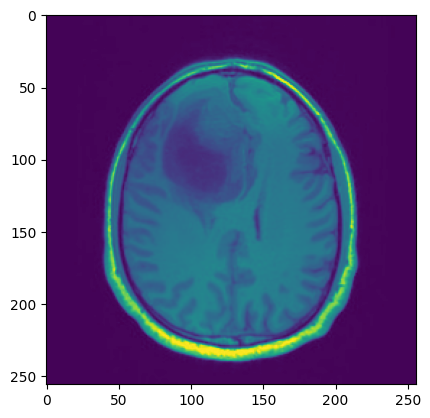

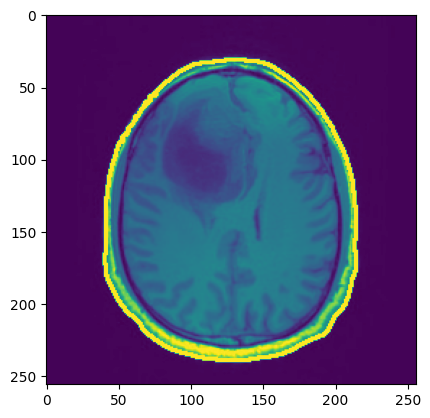

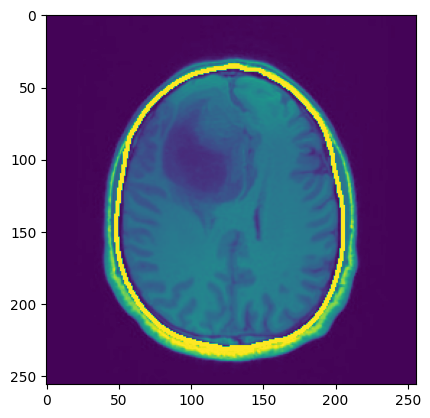

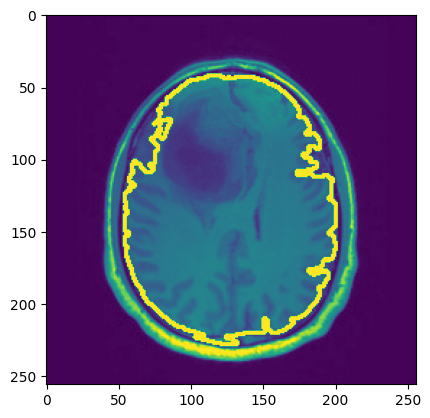

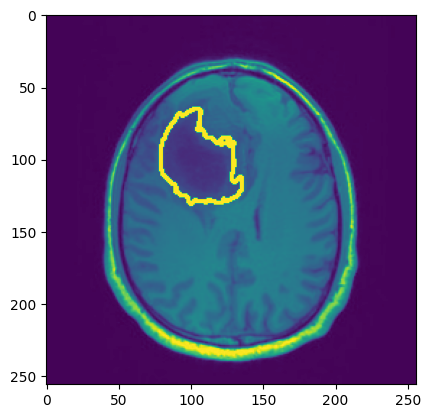

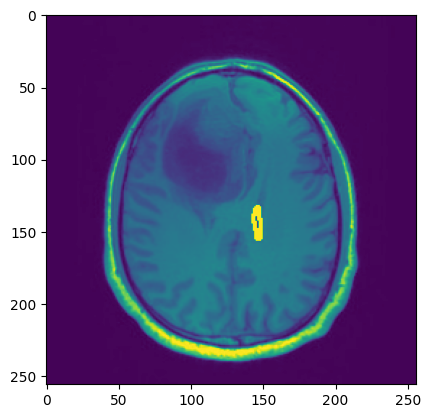

([array([[[124,  31]],
  
         [[123,  32]],
  
         [[122,  32]],
  
         ...,
  
         [[127,  31]],
  
         [[126,  31]],
  
         [[125,  31]]], dtype=int32),
  array([[[126,  36]],
  
         [[127,  35]],
  
         [[128,  35]],
  
         ...,
  
         [[123,  37]],
  
         [[124,  36]],
  
         [[125,  36]]], dtype=int32),
  array([[[112,  42]],
  
         [[111,  43]],
  
         [[110,  43]],
  
         ...,
  
         [[115,  42]],
  
         [[114,  42]],
  
         [[113,  42]]], dtype=int32),
  array([[[101,  66]],
  
         [[102,  65]],
  
         [[103,  65]],
  
         [[104,  65]],
  
         [[105,  65]],
  
         [[106,  66]],
  
         [[107,  67]],
  
         [[107,  68]],
  
         [[106,  69]],
  
         [[106,  70]],
  
         [[106,  71]],
  
         [[106,  72]],
  
         [[106,  73]],
  
         [[106,  74]],
  
         [[105,  75]],
  
         [[106,  76]],
  
         [[106,  77]],
  
   

In [24]:
def visualize_5_largest_contour(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    contrasted = cv2.LUT(image, table)

    #plt.figure()
    #plt.imshow(contrasted)
    #plt.show()

    # apply binary thresholding
    ret, thresh = cv2.threshold(contrasted, 20, 255, cv2.THRESH_BINARY)
    #plt.figure()
    #plt.imshow(thresh)
    #plt.show()

    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE,
                                              method=cv2.CHAIN_APPROX_NONE)

    blank = image.copy()
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    contour_area_dict = {}
    for i in range(len(contours)):
        contour = contours[i]
        blank = image.copy()
        cv2.polylines(img=blank, pts=[contour],
                                     isClosed=True, color=(255), thickness=2)
        contour_area_dict[i] = cv2.contourArea(contour)
        plt.figure()
        plt.imshow(blank)
        plt.show()
    return (contours, contour_area_dict)   
image_path = "/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/shortened_dataset/Astrocitoma T1/0c14dccd685d7ce330d14fa7a1f53dc756e73aff2f03afc1b09a7efc410f1804_big_gallery.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)        
visualize_5_largest_contour(image)

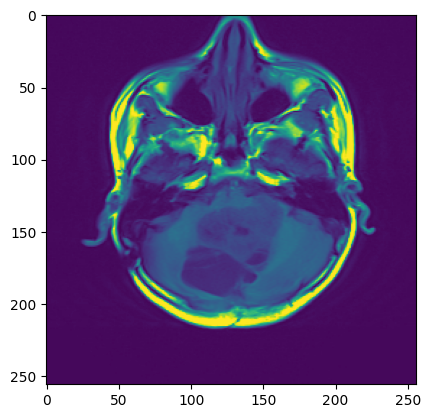

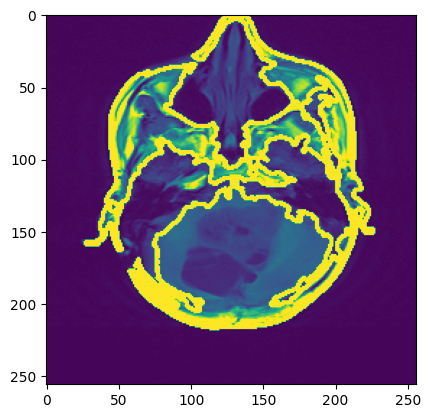

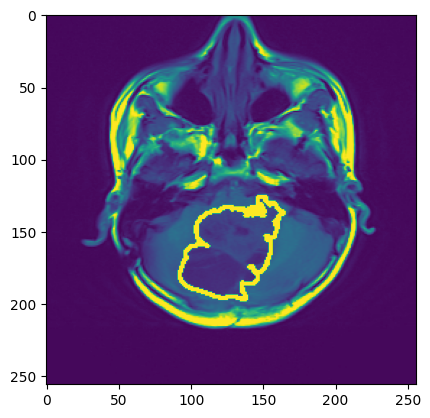

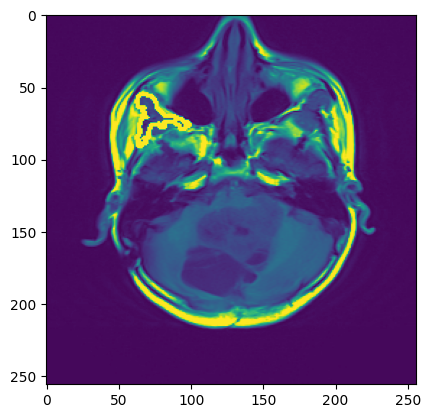

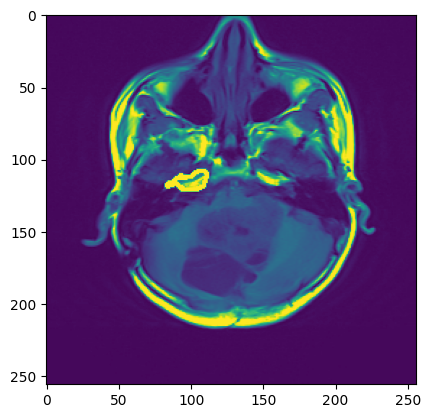

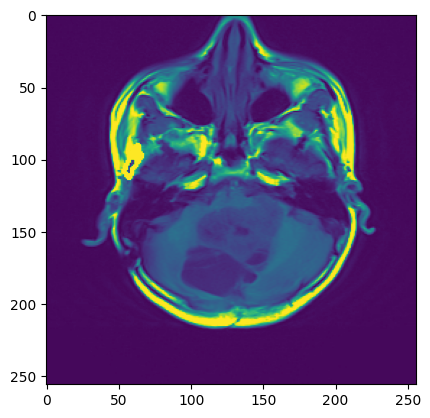

In [21]:
image_path = "/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/shortened_dataset/Meduloblastoma T1/3c6395df24408fb5d7d2fbc297554b9f71b2e852a5df9f31c5877c707fe07b4e_big_gallery.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

visualize_5_largest_contour(image)

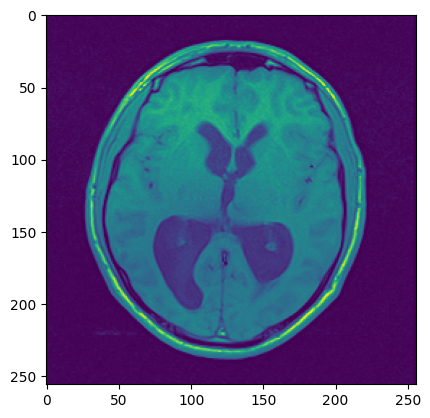

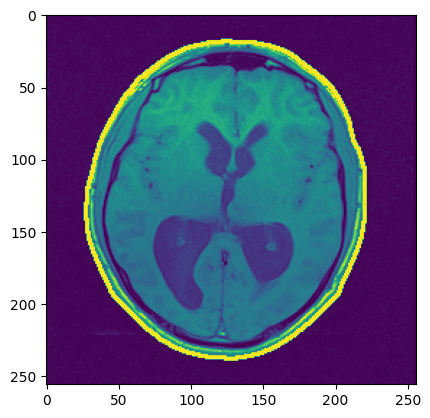

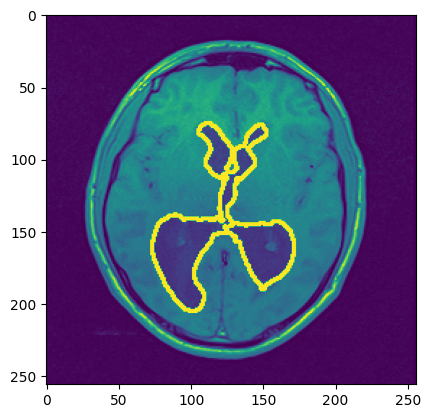

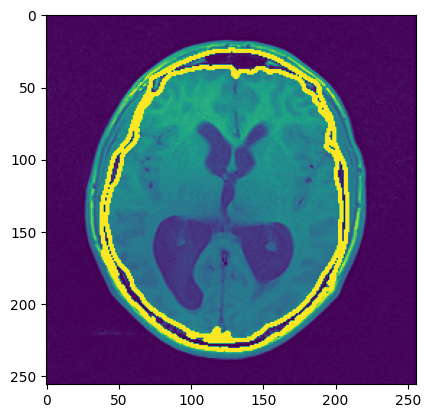

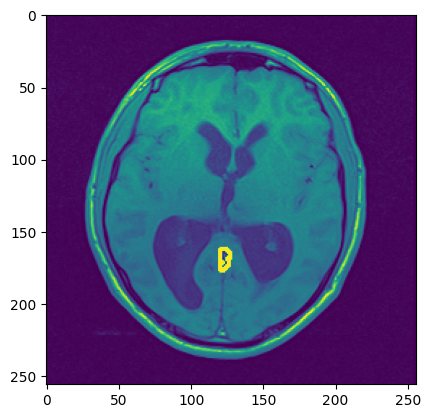

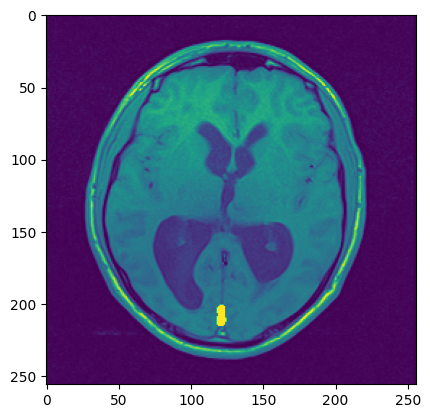

In [22]:
image_path = "/media/khoa-ys/Personal/Projects/ML in Bioinformatics/brain-tumor-classification/shortened_dataset/Germinoma T1/5fbee32de2a58fd2c78ee621115ef1_big_gallery.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

visualize_5_largest_contour(image)

#### Fuzzy C-means segmentation

In [ ]:
image
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 60
attempts=10
ret,label,center=cv2.kmeans(image.astype(np.float32),K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))

plt.imshow(result_image)

In [ ]:
from fcmeans import FCM

w, h = image.shape

temp = image.reshape((w*h, 1))
fcm = FCM(n_clusters=50)                           # create a FCM instance with 10 clusters
fcm.fit(temp)   

res = fcm.predict(temp)                          # get the label of each data point
transformed_image = fcm.centers[res]
transformed_image = transformed_image.reshape(image.shape).astype(np.int8)
plt.imshow(transformed_X)

### Other stuff